In [1]:
import numpy as np
import pandas as pd


import pandas as pd
import seaborn as sns
import numpy as np
sns.set(rc={'figure.figsize':(16,6)}, palette='muted', font_scale = 1.5)

import matplotlib.pyplot as plt

from plotly import tools
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

In [3]:
df = pd.read_csv('pump_sensor.csv',  index_col=1, parse_dates=True)

In [22]:
df = df.iloc[:,1:]

df = df.drop(['sensor_15', 'sensor_50'], axis=1)

for col in df.iloc[:, :-1].columns:

    q01,q99 = np.nanpercentile(df[col],[1,99])

    df.loc[df[col] < q01, col] = np.nan
    df.loc[df[col] > q99, col] = np.nan
#df = df.dropna()
df.fillna(df.mean(), inplace=True)


df = df.loc[df['machine_status'] != 'BROKEN']

df['machine_status'] = df['machine_status'].map({'NORMAL': 0, 'RECOVERING':1})

KeyError: ignored

In [6]:
from sklearn.decomposition import PCA 
pca_transformer = PCA() 
X2 = pca_transformer.fit_transform(df)

df_pca = pd.DataFrame(X2, columns = [f'PCA_{i}' for i in range(51)], index = df.index)

PCA_variance = pd.DataFrame(data=[pca_transformer.explained_variance_ratio_], 
columns = [f'PCA_{i}' for i in range(51)], index=[0])



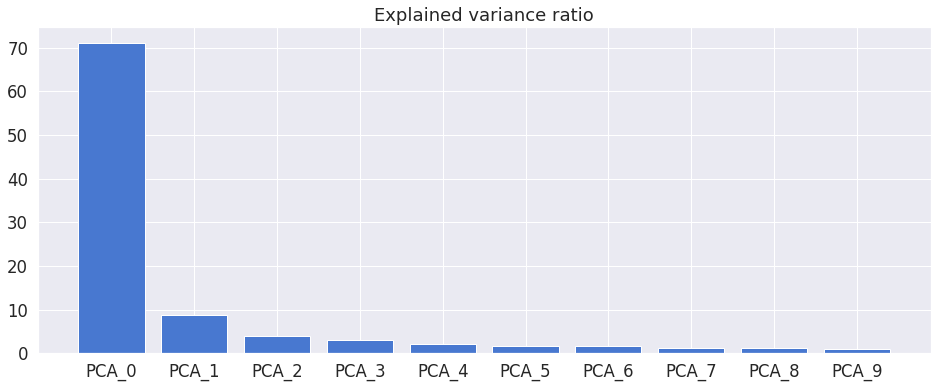

In [ ]:
# Make a random dataset:
height = np.array(PCA_variance.values[0][:10])*100
bars = PCA_variance.columns[:10]
y_pos = np.arange(len(bars))

# Create bars
ax =plt.bar(y_pos, height)

# Create names on the x-axis
plt.xticks(y_pos, bars)

plt.title('Explained variance ratio')


# Show graphic
plt.show()

In [10]:
df_pca = df_pca.iloc[:, :10]
df_pca['machine_status'] = df['machine_status']

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_arr = scaler.fit_transform(df_pca)
dfs = pd.DataFrame(df_arr, columns = df_pca.columns, index = df_pca.index)

for name in dfs.iloc[:, :-1]:
    for j in range(1,61):
        dfs[f'{name}_{j}'] = dfs[name].shift(j)

dfs['machine_status'] = dfs['machine_status'].shift(-60)

dfs = dfs.dropna()

<ipython-input-10-670ca35915e6>:12: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [ ]:
dfs.head(1)

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,...,PCA_9_1,PCA_9_2,PCA_9_3,PCA_9_4,PCA_9_5,PCA_9_6,PCA_9_7,PCA_9_8,PCA_9_9,PCA_9_10
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:10:00,0.276839,0.725214,0.160918,0.445753,0.475064,0.528601,0.413463,0.363172,0.425942,0.380381,...,0.396938,0.388794,0.401161,0.397688,0.406827,0.392699,0.381022,0.397876,0.414701,0.414701


In [11]:
train = dfs.iloc[:120000]
test = dfs.iloc[120000:140000]
val = dfs.iloc[140000:]


x_train = train.drop(['machine_status'], axis=1)
x_test = test.drop(['machine_status'], axis=1)
x_val = val.drop(['machine_status'], axis=1)

x_train = x_train.values.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1], 1))
x_val = x_val.values.reshape((x_val.shape[0], x_val.shape[1], 1))

y_train = train['machine_status'].values
y_test = test['machine_status'].values
y_val = val['machine_status'].values

In [13]:
import matplotlib.pyplot as plt

In [12]:
n_classes = len(np.unique(y_train))

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(rate=dropout)(x)
    res = x + inputs

    # Напишите Feed Forward блок 
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res


In [16]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    #уменьшим выходной тензор части «TransformerEncoder» до вектора признаков для каждой точки данных в текущем батчее
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


In [17]:
class_weight = {0: 1.,
                1: 15.}

## Обучите и оцените качетсво модели (10 баллов)

In [19]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=32,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=256,
    class_weight=class_weight
)

model.evaluate(x_test, y_test, verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 110, 1)]     0           []                               
                                                                                                  
 multi_head_attention_1 (MultiH  (None, 110, 1)      897         ['input_2[0][0]',                
 eadAttention)                                                    'input_2[0][0]']                
                                                                                                  
 dropout_3 (Dropout)            (None, 110, 1)       0           ['multi_head_attention_1[0][0]'] 
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 110, 1)      0           ['dropout_3[0][0]',        

[1.1466717720031738, 0.7833999991416931]

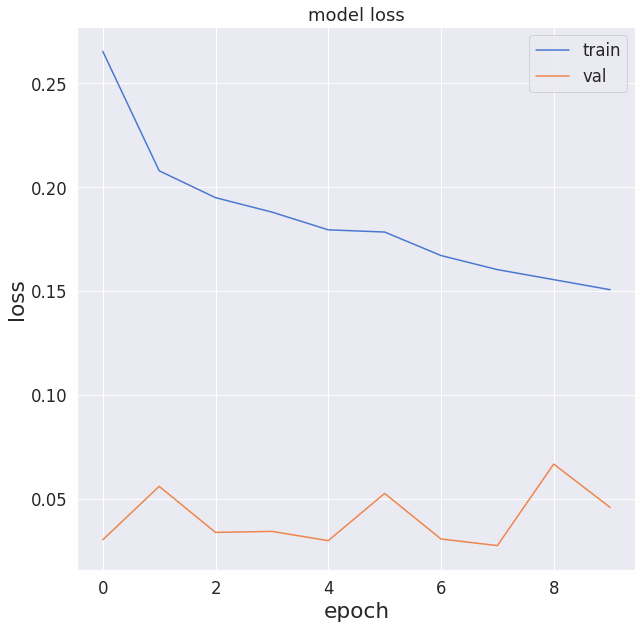

In [20]:
metric = "loss"
plt.figure(figsize=(10,10))
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

625/625 [==============================] - 12s 18ms/step


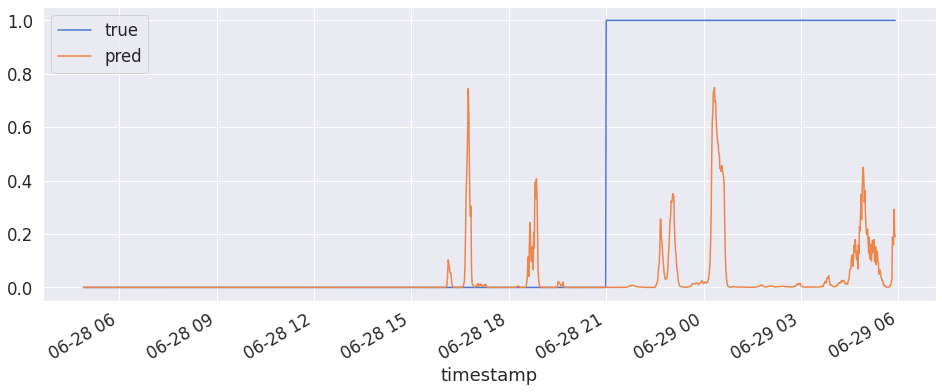

In [21]:
test_preds = model.predict(x_test)
preds_lstm = pd.DataFrame(y_test, index = test.index, columns=['true'])
preds_lstm['pred'] = test_preds.T[1]

preds_lstm.iloc[7000:8500].plot()

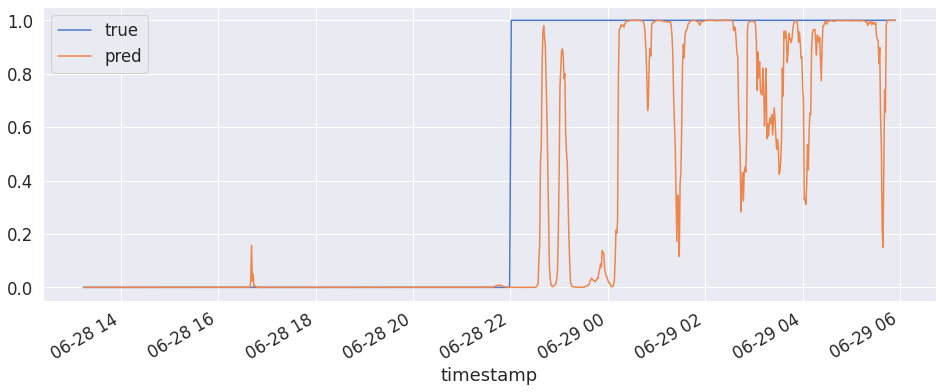

In [ ]:
preds_lstm.iloc[7500:8500].plot()

In [ ]:
test

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,...,PCA_9_1,PCA_9_2,PCA_9_3,PCA_9_4,PCA_9_5,PCA_9_6,PCA_9_7,PCA_9_8,PCA_9_9,PCA_9_10
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-06-23 08:14:00,0.196559,0.333614,0.435821,0.302360,0.401465,0.420734,0.356439,0.365945,0.448455,0.376580,...,0.363080,0.395115,0.352420,0.371191,0.369063,0.342187,0.376342,0.392006,0.393938,0.382040
2018-06-23 08:15:00,0.200693,0.326888,0.412697,0.300746,0.395844,0.431515,0.375829,0.355006,0.432893,0.397772,...,0.376580,0.363080,0.395115,0.352420,0.371191,0.369063,0.342187,0.376342,0.392006,0.393938
2018-06-23 08:16:00,0.194351,0.344711,0.434190,0.307154,0.380991,0.430477,0.389109,0.367363,0.451531,0.383617,...,0.397772,0.376580,0.363080,0.395115,0.352420,0.371191,0.369063,0.342187,0.376342,0.392006
2018-06-23 08:17:00,0.199315,0.342646,0.422148,0.291395,0.381914,0.433993,0.386110,0.363610,0.442881,0.377382,...,0.383617,0.397772,0.376580,0.363080,0.395115,0.352420,0.371191,0.369063,0.342187,0.376342
2018-06-23 08:18:00,0.196334,0.363746,0.421672,0.308661,0.378870,0.398731,0.379951,0.371999,0.444933,0.390828,...,0.377382,0.383617,0.397772,0.376580,0.363080,0.395115,0.352420,0.371191,0.369063,0.342187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-07 05:30:00,0.157150,0.492561,0.395781,0.408538,0.459174,0.524333,0.336279,0.290872,0.402898,0.482540,...,0.486731,0.477286,0.474257,0.488590,0.483566,0.478601,0.476500,0.462013,0.478969,0.475641
2018-07-07 05:31:00,0.143832,0.507685,0.449054,0.469808,0.443027,0.543052,0.341166,0.309771,0.441663,0.449474,...,0.482540,0.486731,0.477286,0.474257,0.488590,0.483566,0.478601,0.476500,0.462013,0.478969
2018-07-07 05:32:00,0.138489,0.514237,0.457608,0.478815,0.439580,0.548605,0.355011,0.306189,0.436388,0.452072,...,0.449474,0.482540,0.486731,0.477286,0.474257,0.488590,0.483566,0.478601,0.476500,0.462013


3750/3750 [==============================] - 8s 2ms/step


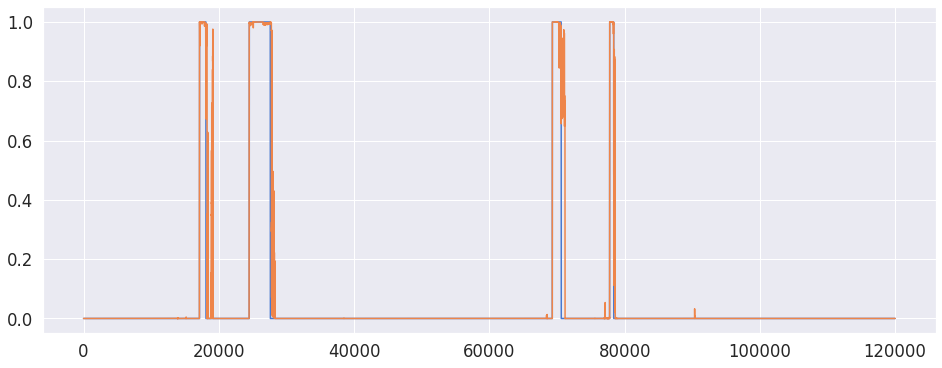

In [ ]:
train_preds = model.predict(x_train)

plt.plot(y_train)
plt.plot(train_preds.T[1])